### Ankle breakers

 Amar Ananth x Manu Singhal x Nikunj Bhatia x Tanish Sanghvi 

#### PROBLEM STATEMENT:

 

##### You are given: 

A) A labeled verified dataset (“Gold Standard”) of about 4,000 tweets. These tweets have been labeled antisemitic/ not antisemitic by expert annotators who went over the same tweets and discussed any disagreements. Tweets were taken out of the dataset if no agreement was found. The tweets in the dataset are from January 2019 to April 2021. The were scraped with one of the four keywords “Jews,” “Israel,” “kikes,” or “ZionNazi*.”

In [ ]:
import pandas as pd
import re
from bert_serving.client import BertClient
from keras.layers import Conv2D
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pickle
import emoji
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pickle
from sklearn.ensemble import VotingClassifier
import numpy as np


#### Function to measure performance of the model.

In [6]:
def performance(x, y):
    
    print(confusion_matrix(x, y))
    
    print(classification_report(x, y))
    print('F-1 score: ',f1_score(x, y, average = 'macro'))
    print('Accuracy: ',accuracy_score(x, y))
    print('Balanced Accuracy: ',balanced_accuracy_score(x, y))
    print('ROC AUC: ', roc_auc_score(x, y,  average = 'macro'))
    
    fpr, tpr, threshold = roc_curve(x, y)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### BERT Client initializer. Execution time can vary.

In [7]:
bc = BertClient(check_length = False)

In [1]:
import pandas as pd
df = pd.read_csv('train_dataset.csv', encoding = 'latin-1')

#### Dropping irrelevant columns.

In [2]:
df.drop(['ID','create_date','user','Sample.ID.x','Sample.ID.y','Still.Exists.x','Still.Exists.y','In.English.x',
         'In.English.y','User.x','User.y','sample_name'],axis=1,inplace=True)

df['Is.About.The.Holocaust.x'] = df['Is.About.The.Holocaust.x'].fillna(df['Is.About.the.Holocaust.x'])
df['Is.About.The.Holocaust.y'] = df['Is.About.The.Holocaust.y'].fillna(df['Is.About.the.Holocaust.y'])
df.drop(['Is.About.the.Holocaust.x','Is.About.the.Holocaust.y'],axis=1,inplace=True)

#### Tweets in general have a lot of unstructured data. It is essential to create a clean transcipt before modelling.

In [3]:
def text_clean(x):

    ### Light
    #x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    x = emoji.demojize(x, language='en')
    
    return x

In [4]:
def cleaning(df, val):

    df.columns = df.columns.str.replace('.', ' ')
    
    df = df.astype(str)
    
    columns = df.columns
    
    df['Full_text']=''
    
    for index, row in df.iterrows():
       
        combined = ""
        
        if row['Sarcasm'] == 'False':
            combined += 'Annotator '+val+' thinks this tweet is not sarcastic. '
        else:
            combined += 'Annotator '+val+' thinks this tweet is sarcastic. '
        
        if row['Disagree With'] == 'True':
            combined += 'Annotator '+val+' thinks this tweet is anti-semitic but cannot justify it with the IHRA guidelines. '  
        
        if row['Is About The Holocaust'] == '0.0':
            combined += 'Annotator '+val+' thinks this tweet is not about the holocaust. '
        else:
            combined += 'Annotator '+val+' thinks this tweet is about the holocaust. '
            
        if row['IHRA Section'] == '13':
            combined += 'Annotator '+val+' thinks that this tweet does not fall under IHRA guidelines and is therefore not anti-semitic. '
        else:
            combined += 'Annotator '+val+' thinks that this tweet falls under IHRA guideline '+row['IHRA Section']+' and is therefore anti-semitic. '
        
        if row['Calling Out'] == '0':
            combined += 'Annotator '+val+' thinks this tweet is not calling out anti-semitics. '
        else:
            combined += 'Annotator '+val+' thinks this tweet is calling out anti-semitics. '
        
        if row['Sentiment Rating']=='1':
            combined += 'Annotator '+val+' thinks that this tweet is very negative. '
        elif row['Sentiment Rating']=='2':
            combined += 'Annotator '+val+' thinks that this tweet is negative. '
        elif row['Sentiment Rating']=='3':
            combined += 'Annotator '+val+' thinks that this tweet is neutral. '
        elif row['Sentiment Rating']=='4':
            combined += 'Annotator '+val+' thinks that this tweet is positive. '
        else:
            combined += 'Annotator '+val+' thinks that this tweet is very positive. '
        
        if row['Additional Comments'] != 'No comments.':
            combined += 'Additional comments by Annotator '+val+': {:}'.format(row['Additional Comments']) 
        
        df['Full_text'][index] = combined
        
    return df
        

In [7]:
import re
import emoji

df_x = df.loc[:, df.columns.str.endswith(".x")]
df_x.columns = df_x.columns.str.rstrip('.x')

clean_df_x = cleaning (df_x, 'X')

df_y = df.loc[:, df.columns.str.endswith(".y")]
df_y.columns = df_y.columns.str.rstrip('.y')

clean_df_y = cleaning (df_y, 'Y')

df['Text_x'] = clean_df_x['Full_text']
df['Text_y'] = clean_df_y['Full_text']

df['full_text']=df['full_text'].apply(lambda x: text_clean(str(x)))
df['Text_x']=df['Text_x'].apply(lambda x: text_clean(str(x)))
df['Text_y']=df['Text_y'].apply(lambda x: text_clean(str(x)))

    

<ipython-input-4-068b001e860b>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', ' ')
<ipython-input-4-068b001e860b>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', ' ')


In [8]:
df['Full_Text'] = ''

for index, row in df.iterrows():
   
    combined = ""
    
    combined += row["full_text"]
    
    combined += "\n\n"

    combined += row["Text_x"]
    
    combined += "\n\n"

    combined += row["Text_y"]

    df['Full_Text'][index] = combined

<ipython-input-8-7641c184bccd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Full_Text'][index] = combined


#### Some basic exploration

In [13]:
df.columns

Index(['key', 'userID', 'RT_TF', 'full_text', 'Sarcasm.x', 'Sarcasm.y',
       'Additional.Comments.x', 'Additional.Comments.y', 'Disagree.With.x',
       'Disagree.With.y', 'Sentiment.Rating.x', 'Sentiment.Rating.y',
       'Calling.Out.x', 'Calling.Out.y', 'IHRA.Section.x', 'IHRA.Section.y',
       'Is.About.The.Holocaust.x', 'Is.About.The.Holocaust.y', 'Target',
       'Text_x', 'Text_y', 'Full_Text'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   key                       3216 non-null   object 
 1   userID                    3216 non-null   float64
 2   RT_TF                     3216 non-null   bool   
 3   full_text                 3216 non-null   object 
 4   Sarcasm.x                 3216 non-null   bool   
 5   Sarcasm.y                 3216 non-null   bool   
 6   Additional.Comments.x     3216 non-null   object 
 7   Additional.Comments.y     3216 non-null   object 
 8   Disagree.With.x           3216 non-null   bool   
 9   Disagree.With.y           3216 non-null   bool   
 10  Sentiment.Rating.x        3216 non-null   int64  
 11  Sentiment.Rating.y        3216 non-null   int64  
 12  Calling.Out.x             3216 non-null   int64  
 13  Calling.Out.y             3216 non-null   int64  
 14  IHRA.Sec

In [15]:
df.isnull().sum()

key                         0
userID                      0
RT_TF                       0
full_text                   0
Sarcasm.x                   0
Sarcasm.y                   0
Additional.Comments.x       0
Additional.Comments.y       0
Disagree.With.x             0
Disagree.With.y             0
Sentiment.Rating.x          0
Sentiment.Rating.y          0
Calling.Out.x               0
Calling.Out.y               0
IHRA.Section.x              0
IHRA.Section.y              0
Is.About.The.Holocaust.x    0
Is.About.The.Holocaust.y    0
Target                      0
Text_x                      0
Text_y                      0
Full_Text                   0
dtype: int64

In [16]:
df.full_text.value_counts()

Richard Spencer is a fucking Nazi.\nDon believe it?\nListen to this.\n\n\Little fucking kikes, they get ruled by people like me. Little fucking octaroons. My ancestors enslaved those pieces of fucking shit.\ via @Avi_Bueno\n#mondaymorning @mondaymotivation \n     40
Fun fact for Holocaust Remembrance Day: this was the same tactic used to keep European Jews out of the United States in the .                                                                                                                                            7
#Apartheid zionazist...\nEthnic cleansing, land seizure, home demolition, military occupation, bombing of Gaza..\nIsrael is copying South Africa very well #SobatPalestinaINA #IsraeliCrimes                                                                             7
Dear Jews, Hindus are your fiercest allies but you need to educate Jewish communities about Hindus Very Important Read                                                                                 

In [17]:
df.key.value_counts()

JewNAS        1763
IsraelNAS      505
ZioNaziAS      365
JewAS          222
KikesNAS       150
KikesAS         79
IsraelAS        77
ZioNaziNAS      55
Name: key, dtype: int64

In [18]:
df['IHRA.Section.x'].value_counts()

13    2397
10     356
2      194
7       93
0       70
4       55
9       19
1       12
3        6
11       5
5        5
6        4
Name: IHRA.Section.x, dtype: int64

<AxesSubplot:>

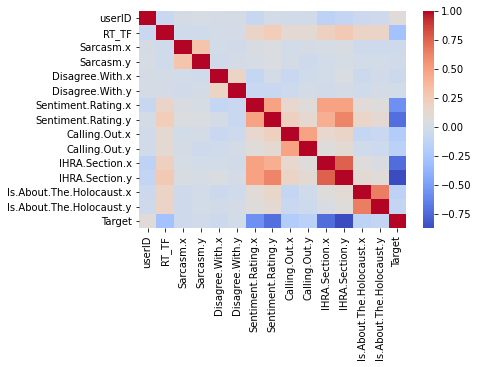

In [20]:
import seaborn as sns
sns.heatmap(df.corr(),cmap='coolwarm')

In [21]:
df_3 = df
df_3['length']=df['full_text'].apply(len)

#### Distribution of text lengths of tweets with respect to our target column

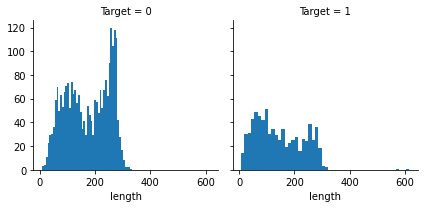

In [22]:
import matplotlib.pyplot as plt
g=sns.FacetGrid(df_3,col='Target')
g.map(plt.hist,'length',bins=50)

<AxesSubplot:xlabel='Target', ylabel='length'>

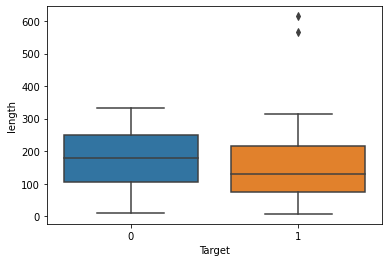

In [23]:
sns.boxplot(x='Target',y='length',data=df_3)

In [24]:
df_3.groupby('Target').mean()[['length']]

,length
Target,
0,174.671654
1,145.353970


In [9]:
df1 = df[df['key'].isin(['IsraelNAS', 'JewNAS', 'IsraelAS', 'JewAS'])]
df2 = df[df['key'].isin(['ZioNaziAS', 'ZioNaziNAS', 'KikesNAS', 'KikesAS'])]

In [15]:
X1 = df1['Full_Text']
X1 = bc.encode(list(X1))
y1 = df1['Target']

X2 = df2['Full_Text']
X2 = bc.encode(list(X2))
y2 = df2['Target']

#### Deployed a CNN in order to train and predict on test data.

In [16]:
def cnn_model(X_train, y_train):

    model = tf.keras.Sequential([tf.keras.layers.Conv1D(512, 3, activation='relu'),
                          tf.keras.layers.MaxPooling1D(pool_size = 2),
                          tf.keras.layers.Conv1D(128, 3, activation='relu'),
                          tf.keras.layers.MaxPooling1D(pool_size = 2),
                          #tf.keras.layers.Conv1D(32, 3, activation='relu'),
                          #tf.keras.layers.MaxPooling1D(pool_size = 2),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(64, activation='relu'),
                          tf.keras.layers.Dropout(0.1),
                          #tf.keras.layers.Dense(32, activation='relu'),
                          #tf.keras.layers.Dropout(0.1),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                          ])
    
    model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                      metrics = ['accuracy'])
    
    model.fit(X_train, y_train, batch_size=100, epochs=15)
    
    return model

#### Tried a variety of parameters and we have finalized on this for the given training set. Challenging task because of the convoluted dataset that was provided.

In [17]:
#Model 1

over = SMOTE(sampling_strategy=0.3)
X_over, y_over = over.fit_resample(X1, y1)

X_new = X_over.reshape(-1, 768, 1)
#X_train, X_test, y_train, y_test = train_test_split(X_new,y_over,test_size=0.2)
model1 = cnn_model(X_new, y_over)

#Model 2

X_new = X2.reshape(-1, 768, 1)
#X_train, X_test, y_train, y_test = train_test_split(X_new, y2, test_size=0.2)
model2 = cnn_model(X_new, y2)


Epoch 1/15


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 18s 558ms/step - loss: 0.5536 - accuracy: 0.7676
Epoch 2/15
30/30 [==============================] - 16s 546ms/step - loss: 0.5053 - accuracy: 0.7693
Epoch 3/15
30/30 [==============================] - 17s 554ms/step - loss: 0.4426 - accuracy: 0.7693
Epoch 4/15
30/30 [==============================] - 16s 546ms/step - loss: 0.4077 - accuracy: 0.7893
Epoch 5/15
30/30 [==============================] - 16s 543ms/step - loss: 0.3597 - accuracy: 0.8161
Epoch 6/15
30/30 [==============================] - 16s 540ms/step - loss: 0.3328 - accuracy: 0.8294
Epoch 7/15
30/30 [==============================] - 16s 546ms/step - loss: 0.3150 - accuracy: 0.8484
Epoch 8/15
30/30 [==============================] - 16s 539ms/step - loss: 0.3132 - accuracy: 0.8552
Epoch 9/15
30/30 [==============================] - 16s 545ms/step - loss: 0.2806 - accuracy: 0.8684
Epoch 10/15
30/30 [==============================] - 17s 553ms/step - loss: 0.2703 - accuracy: 0.8708


In [18]:
#Test data set
df = pd.read_csv('/Users/apple/Downloads/test_dataset (1).csv', encoding = 'latin-1')

df.drop(['ID','create_date','user','Sample.ID.x','Sample.ID.y','Still.Exists.x','Still.Exists.y','In.English.x',
         'In.English.y','User.x','User.y','sample_name'],axis=1,inplace=True)

df['Is.About.The.Holocaust.x'] = df['Is.About.The.Holocaust.x'].fillna(df['Is.About.the.Holocaust.x'])
df['Is.About.The.Holocaust.y'] = df['Is.About.The.Holocaust.y'].fillna(df['Is.About.the.Holocaust.y'])
df.drop(['Is.About.the.Holocaust.x','Is.About.the.Holocaust.y'],axis=1,inplace=True)


In [19]:
df_x = df.loc[:, df.columns.str.endswith(".x")]
df_x.columns = df_x.columns.str.rstrip('.x')

clean_df_x = cleaning (df_x, 'X')

df_y = df.loc[:, df.columns.str.endswith(".y")]
df_y.columns = df_y.columns.str.rstrip('.y')

clean_df_y = cleaning (df_y, 'Y')

df['Text_x'] = clean_df_x['Full_text']
df['Text_y'] = clean_df_y['Full_text']

df['full_text']=df['full_text'].apply(lambda x: text_clean(str(x)))
df['Text_x']=df['Text_x'].apply(lambda x: text_clean(str(x)))
df['Text_y']=df['Text_y'].apply(lambda x: text_clean(str(x)))


In [20]:
df['Full_Text'] = ''

for index, row in df.iterrows():
   
    combined = ""
    
    combined += row["full_text"]
    
    combined += "\n\n"

    combined += row["Text_x"]
    
    combined += "\n\n"

    combined += row["Text_y"]

    df['Full_Text'][index] = combined


<ipython-input-20-7641c184bccd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Full_Text'][index] = combined


In [23]:
df_new= pd.DataFrame(zip(df['Full_Text'], df['key']), columns=("Full_Text", "Key"))

df_new['row_num'] = np.arange(len(df_new))

In [24]:
df_1 = df_new[df_new['Key'].isin(['IsraelNAS', 'JewNAS', 'IsraelAS', 'JewAS'])]
df_2 = df_new[df_new['Key'].isin(['ZioNaziAS', 'ZioNaziNAS', 'KikesNAS', 'KikesAS'])]


In [25]:
X1 = df_1['Full_Text']
X1 = bc.encode(list(X1))
X1_new = X1.reshape(-1, 768, 1)
prediction1 = model1.predict(X1_new, batch_size = 100).round()

In [26]:
X2 = df_2['Full_Text']
X2 = bc.encode(list(X2))
X2_new = X2.reshape(-1, 768, 1)
prediction2 = model2.predict(X2_new, batch_size = 100).round()

In [27]:
pred1 = []
for item in prediction1:
    pred1.append(int(item[0]))

pred2 = []
for item in prediction2:
    pred2.append(int(item[0]))

In [28]:
df_pred = pd.concat([pd.DataFrame(zip(pred1, df_1['row_num']), columns=("Target", "row_num")), pd.DataFrame(zip(pred2, df_2['row_num']), columns=("Target", "row_num"))])
df_pred.sort_values("row_num")
df_pred = df_pred.reset_index(drop=True)
df['Target']=df_pred['Target']

#### Prediction results are finally generated and stored. These have been uploaded by the team.

In [ ]:
res = pd.DataFrame(df_pred['Target']) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = df.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["Target"]
res.to_csv("prediction_results.csv", index = False)      # the csv file will be saved locally on the same location where this notebook is located.

#### NER

In [25]:
import pandas as pd
import spacy
import nltk
#!pip install wordninja
import wordninja
#!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()
import spacy 
nlp = spacy.load("en_core_web_sm")
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 


df = df

In order to get clean textual transcript of the tweet, we are cleaning the URLs, emojis and retweets.

In [26]:
#!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

In [27]:
clean_text = []
for i in df['full_text'].tolist():
    clean_text.append(p.clean(i))

In [28]:
df_11 = df
df_11['full_text_clean'] = clean_text

We are performing the process of stemming, that reduces a given word into its base form. This is a necessary step when utilizing visualizations like WordCloud.

In [29]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

#### Target = 1

Let's have a look at the wordcloud for when our Target variable is 1

In [30]:
list_1 = []
import re
for i in df_11[df_11['Target'] == 1]['full_text_clean'].to_list():
    
    i = re.sub(r'[^\w\s]','',i)
    split = i.split(' ')
    doc = nlp(i)
    for ent in doc.ents: 
        if(ent.label_ in ['GPE', 'ORG', 'PERSON', 'LOC', 'NORP']):
            list_1.append([ps.stem(ent.text).lower(), ent.label_])  

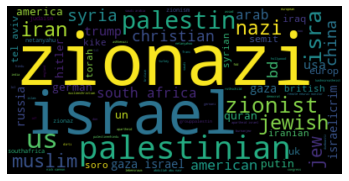

In [31]:
list_2 = [list_1[i][0] for i in range(0,len(list_1))]
from collections import Counter
bag = dict(Counter(list_2))
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=bag)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can clearly see that there are certain groups or entities that are being more often for this category. 

##### Zionazi, israel, palestine, christian, china, us

#### Target = 0

Let's have a look at the wordcloud for when our Target variable is 0

In [33]:
list_1 = []
import re
for i in df_11[df_11['Target'] == 0]['full_text_clean'].to_list():
    
    i = re.sub(r'[^\w\s]','',i)
    split = i.split(' ')
    doc = nlp(i)
    for ent in doc.ents: 
        if(ent.label_ in ['GPE', 'ORG', 'PERSON', 'LOC', 'NORP']):
            list_1.append([ps.stem(ent.text).lower(), ent.label_])  

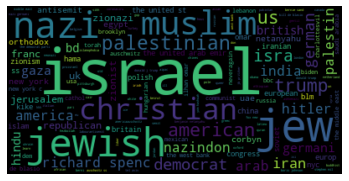

In [34]:
list_2 = [list_1[i][0] for i in range(0,len(list_1))]
from collections import Counter
bag = dict(Counter(list_2))
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=bag)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### israel, jewish, palestine, muslim, american, trump, hitler

Target cateogry 0 has more people mentioned.